# Numpyro and Hamiltonian Monte Carlo

In this tutorial we will see how we to integrate our ∂Lux optical models with a Probablistic Programming Language (PPL) Numpyro. This allows us to run a subset of MCMC algorithms known as HMC, that take advantage of autodiff in order to infer the relationship between a large number of parameters.

In this example we will simulate a binary star through a simple optical system, and simultanesouly infer the parameters of the stars and the state of the optical system at the same time.

---

In [1]:
# Core jax
import jax
import jax.numpy as np
import jax.random as jr

# PPL
import numpyro as npy
import numpyro.distributions as dist

# Set CPU count for numpyro multi-chain multi-thread
import os
os.environ["XLA_FLAGS"] = '--xla_force_host_platform_device_count=2'

# Optimisation
import equinox as eqx
import optax

# Optics
import dLux as dl

# Plotting/visualisation
import matplotlib.pyplot as plt
import chainconsumer as cc

# Set global plotting parameters
%matplotlib inline
plt.figure()
plt.rcParams['image.cmap'] = 'inferno'
plt.rcParams["font.family"] = 'serif'
plt.rcParams["text.usetex"] = 'true'
plt.rcParams['figure.dpi'] = 120

<Figure size 432x288 with 0 Axes>

First we want to create our spectral object for our binary star source, and then create the binary star object

In [5]:
# Create Combined Spectrum for Binary
nwavels = 3
wavels = np.linspace(400e-9, 500e-9, nwavels)
wavelengths = [wavels, wavels]
weights = [np.ones(nwavels), np.linspace(0.5, 1, nwavels)]
combined_spectrum = dl.CombinedSpectrum(wavelengths, weights)

# Create Binary Source
true_position = np.zeros(2)
true_separation, true_field_angle = dl.utils.arcsec2rad(1e-1), 0
true_flux, true_flux_ratio = 1e5, 2
resolved = [False, False]
binary_source = dl.BinarySource(true_position, true_flux, true_separation, 
                             true_field_angle, true_flux_ratio, 
                             combined_spectrum, resolved, name="Binary")

Next we define the optical system and detector, and combine then with the binary soure in order to create a telescope object that we will use to model all of these components simultaneously.

In [17]:
# Construct Optical system
wf_npix = 128
det_npix = 128

# Zernike aberrations
basis = dl.utils.zernike_basis(10, npix=wf_npix)[3:] * 1e-9
true_coeffs = jr.normal(jr.PRNGKey(0), (basis.shape[0],))

# Construct optical layers
true_pixel_scale = dl.utils.arcsec2rad(5e-3)
layers = [dl.CreateWavefront(wf_npix, 1),
          dl.TiltWavefront(),
          dl.CompoundAperture([0.5]),
          dl.ApplyBasisOPD(basis, true_coeffs),
          dl.NormaliseWavefront(),
          dl.AngularMFT(true_pixel_scale, det_npix)]

# Construct Detector
true_bg = 10.
true_pixel_response = 1 + 0.05*jr.normal(jr.PRNGKey(0), (det_npix, det_npix))
detector_layers = [
    dl.AddConstant(true_bg),
    # dl.ApplyPixelResponse(true_pixel_response)
]

# Construct Telescope
telescope = dl.Telescope(dl.Optics(layers), 
                         dl.Scene([binary_source]),
                         detector=dl.Detector(detector_layers))

Now lets create the fake data and examine it. Note that for Numpyro we will flatten our data to make it easier to interact with

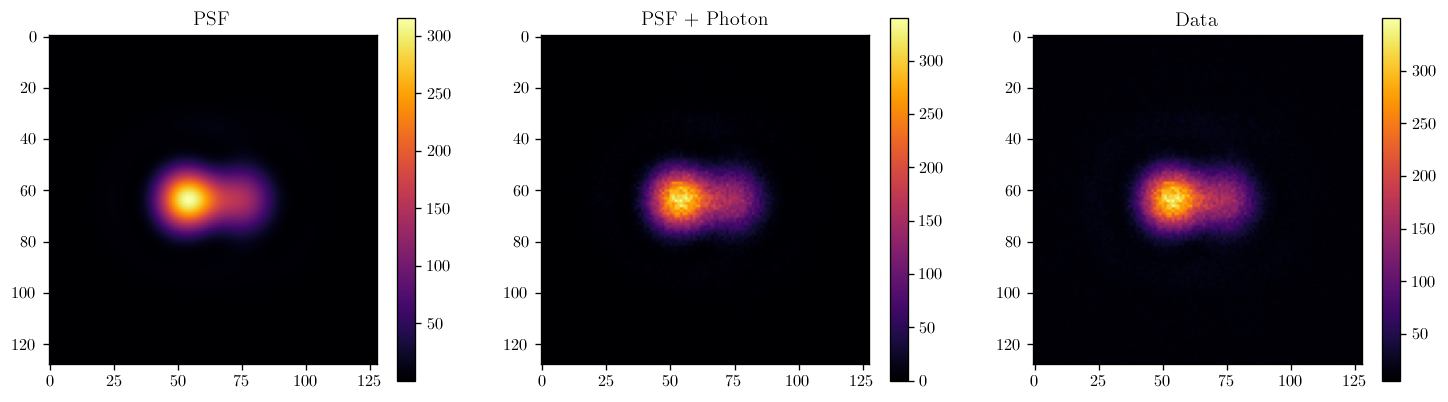

In [18]:
## Gerenate psf
psf = telescope.model_scene()
psf_photon = jr.poisson(jr.PRNGKey(0), psf)
bg_noise = true_bg + jr.normal(jr.PRNGKey(0), psf_photon.shape)
image = psf_photon+bg_noise
data = image.flatten()

plt.figure(figsize=(15, 4))
plt.subplot(1, 3, 1)
plt.title("PSF")
plt.imshow(psf)
plt.colorbar()

plt.subplot(1, 3, 2)
plt.title("PSF + Photon")
plt.imshow(psf_photon)
plt.colorbar()

plt.subplot(1, 3, 3)
plt.title("Data")
plt.imshow(image)
plt.colorbar()
plt.show()

---

# Inference with Numpyro

Awesome, now we are going to try and infer these parameters using an MCMC algortihm. There a few different parameters we want to learn:

##  Binary parameters
 - The (x,y) mean position (2 parameters)
 - The separation (1 parameter)
 - The position angle (1 parameter)
 - The mean flux (1 parameter)
 - The contrast ratio (1 parameter)
 
## Optical parameters
 - The zernike aberration coefficients (7 parameters)
 
## Detector parameters
 - The mean detector noise (1 parameter)
 
This gives us a total of 14 parameters, which is quite high dimensional for regular MCMC algortihms.

---


In order to be able to refer to these individual parameters, we will construct a parameter dictionary. If you haven't seen this before check out [this tutorial!](https://louisdesdoigts.github.io/dLux/notebooks/PyTree_interface/)

In [19]:
# Lets define our path dict to simplify accessing these attributes
path_dict = {
    'pos'    : ['scene',    'sources', 'Binary',             'position'       ],
    'sep'    : ['scene',    'sources', 'Binary',             'separation'     ],
    'angle'  : ['scene',    'sources', 'Binary',             'field_angle'    ],
    'flx'    : ['scene',    'sources', 'Binary',             'flux'           ],
    'cont'   : ['scene',    'sources', 'Binary',             'flux_ratio'     ],
    'zern'   : ['optics',   'layers',  'Apply Basis OPD',    'coeffs'         ],
    'pscale' : ['optics',   'layers',  'AngularMFT',         'pixel_scale_out'],
    'bg'     : ['detector', 'layers',  'AddConstant',        'value'          ],
    'FF'     : ['detector', 'layers',  'ApplyPixelResponse', 'pixel_response' ],
    }

Now we construct our Numpyro sampling function. In this function we need to define priors distribution variables for our parameters, and feed them (along with the corresponsing path to that parameter in the model) into the .update_and_model() function. This allows for Numpyro to simulatensly sample the posterior for all of the parameters bu taking advantage of the differentiable nature of these models. 

With these parameters we define a 'plate' which defines our data, using a Possion likelihood since this is our dominant noise source.

In [31]:
dl.utils.rad2arcsec(telescope.get_leaf(['pscale'], path_dict=path_dict))

DeviceArray(0.005, dtype=float32)

In [72]:
def psf_model(data, model, path_dict=None):
    """
    Define the numpyro function
    """
    # Define empty paths and values lists to append to
    paths, values = [], []
    
    # Position
    position_pix = npy.sample("position_pix", dist.Uniform(-10, 10), sample_shape=(2,))
    position     = npy.deterministic('position', position_pix*true_pixel_scale)
    paths.append('pos'), values.append(position)
    
    # Separation
    sep_min = true_separation - 10*true_pixel_scale
    sep_max = true_separation + 10*true_pixel_scale
    separation_log = npy.sample("log_separation", dist.Uniform(np.log10(sep_min), np.log10(sep_max)))
    separation     = npy.deterministic('separation', 10**(separation_log))
    paths.append('sep'), values.append(separation)
    
    # Field Angle (Position Angle)
    theta_x = npy.sample("theta_x", dist.Normal(0, 1))
    theta_y = npy.sample("theta_y", dist.Normal(0, 1))
    field_angle = npy.deterministic('field_angle', np.arctan2(theta_y, theta_x))
    paths.append('angle'), values.append(field_angle)
    
    # Flux
    flux_log = npy.sample("log_flux", dist.Uniform(4, 8))
    flux     = npy.deterministic('flux', 10**flux_log)
    paths.append('flx'), values.append(flux)
    
    # Flux ratio
    flux_ratio_log = npy.sample("log_flux_ratio", dist.Uniform(0, 4))
    flux_ratio     = npy.deterministic('flux_ratio', 10**flux_ratio_log)
    paths.append('cont'), values.append(flux_ratio)
    
    # Zernikes
    coeffs = npy.sample("coeffs", dist.Normal(0, 1), sample_shape=true_coeffs.shape)
    paths.append('zern'), values.append(coeffs)
    
    # Plate scale
    pscale_raw = npy.sample("pixel_scale_raw", dist.Uniform(0.8, 1.2))
    pscale     = npy.deterministic('pixel_scale', true_pixel_scale * pscale_raw)
    paths.append('pscale'), values.append(pscale)
    
    # Background
    bg = npy.sample("bg", dist.Uniform(5, 15))
    paths.append('bg'), values.append(bg)

    with npy.plate("data", len(data)):
        poisson_model = dist.Poisson(model.update_and_model(
            "model_image", paths, values, path_dict=path_dict, flatten=True))
        return npy.sample("psf", poisson_model, obs=data)

Now we can use the numpyro.render_model() function to check to make sure everything is being fed in correctly

In [73]:
# npy.render_model(psf_model, model_args=(data, telescope, path_dict))

Using the model above, we can now sample from the posterior distribution using the No U-Turn Sampler (NUTS).

In [74]:
sampler = npy.infer.MCMC(
    npy.infer.NUTS(psf_model),    
    num_warmup=1000,
    num_samples=2000,
    num_chains=2,
    progress_bar=True,
)
%time sampler.run(jr.PRNGKey(0), data, telescope, path_dict=path_dict)

  0%|          | 0/3000 [00:00<?, ?it/s]

  0%|          | 0/3000 [00:00<?, ?it/s]

CPU times: user 1h 19min 36s, sys: 6min 26s, total: 1h 26min 3s
Wall time: 16min 39s


In [75]:
sampler.print_summary()
values_out = sampler.get_samples()


                       mean       std    median      5.0%     95.0%     n_eff     r_hat
               bg     10.00      0.03     10.00      9.96     10.05   2784.62      1.00
        coeffs[0]      0.02      0.97      0.01     -1.50      1.70   1709.66      1.00
        coeffs[1]      0.00      1.00     -0.02     -1.52      1.79   2626.01      1.00
        coeffs[2]     -0.02      0.93     -0.03     -1.46      1.60   2701.61      1.00
        coeffs[3]      0.37      0.28      0.37     -0.05      0.87   1683.19      1.00
        coeffs[4]     -1.18      0.22     -1.18     -1.55     -0.84   2412.24      1.00
        coeffs[5]      1.92      0.27      1.92      1.48      2.35   3180.10      1.00
        coeffs[6]     -0.51      0.25     -0.51     -0.88     -0.08   2232.08      1.00
         log_flux      5.00      0.00      5.00      5.00      5.00   3413.78      1.00
   log_flux_ratio      0.30      0.00      0.30      0.30      0.31   2630.72      1.00
   log_separation     -6.31    

In [132]:
def make_dict(dict_in, truth=False):
    """
    Just a convenience formatting function to latexise parameter names
    for plotting
    """
    znames = ['Focus', 'Astig45', 'Astig0', 'ComaY', 'ComaX', 'TfoilY', 'TfoilX']
    pos_names = ['Pos$_x$', 'Pos$_y$']
    name_dict = {'separation': 'r', 
                 'field_angle': r'$\phi$',
                 'flux_ratio': 'Contrast', 
                 'flux':  r'$\overline{flux}$',
                 'bg': '$\mu_{BG}$', 
                 'bg_var': '$\sigma_{BG}$',
                 'pixel_scale':  'pixscale'}
    
    dict_out = {}
    keys = list(dict_in.keys())
    for i in range(len(keys)):
        key = keys[i]
        if 'latent' in key or 'log' in key or 'theta' in key or '_pix' in key or '_raw' in key:# or key == 'bg':
            continue
        item = dict_in[key]
        if key == 'position':
            for j in range(item.shape[-1]):
                dict_out[pos_names[j]] = item[j] if truth else item[:, j]
                    
        elif key == 'coeffs':
            for j in range(item.shape[-1]):
                dict_out[znames[j]] = item[j] if truth else item[:, j]
        else:
            dict_out[name_dict[key]] = item
    
    # Now re-order for nicer plotting
    order = ['r', r'$\phi$', 'Pos$_x$', 'Pos$_y$', r'$\overline{flux}$', 'Contrast', '$\\mu_{BG}$', 'pixscale', 'Focus', 'Astig45', 'Astig0', 'ComaY', 'ComaX', 'TfoilY', 'TfoilX']
    new_dict = {}
    for key in order:
        new_dict[key] = dict_out[key]
    return new_dict

In [133]:
# Format chains for plotting
truth_dict = {'bg':          true_bg,          'coeffs':   true_coeffs, 
              'field_angle': true_field_angle, 'flux':     true_flux, 
              'flux_ratio':  true_flux_ratio,  'position': true_position, 
              'separation':  true_separation,  'bg_var':   1.,
              'pixel_scale': true_pixel_scale}

truth_dict_in = make_dict(truth_dict, truth=True)
chain_dict = make_dict(values_out)

['$\\mu_{BG}$', 'Focus', 'Astig45', 'Astig0', 'ComaY', 'ComaX', 'TfoilY', 'TfoilX', '$\\phi$', '$\\overline{flux}$', 'Contrast', 'Pos$_x$', 'Pos$_y$', 'r', '$\\sigma_{BG}$', 'pixscale']
['$\\mu_{BG}$', 'Focus', 'Astig45', 'Astig0', 'ComaY', 'ComaX', 'TfoilY', 'TfoilX', '$\\phi$', '$\\overline{flux}$', 'Contrast', 'pixscale', 'Pos$_x$', 'Pos$_y$', 'r']


In [134]:
# truth_dict_in

In [136]:
chain_dict['r'] = chain_dict['r']

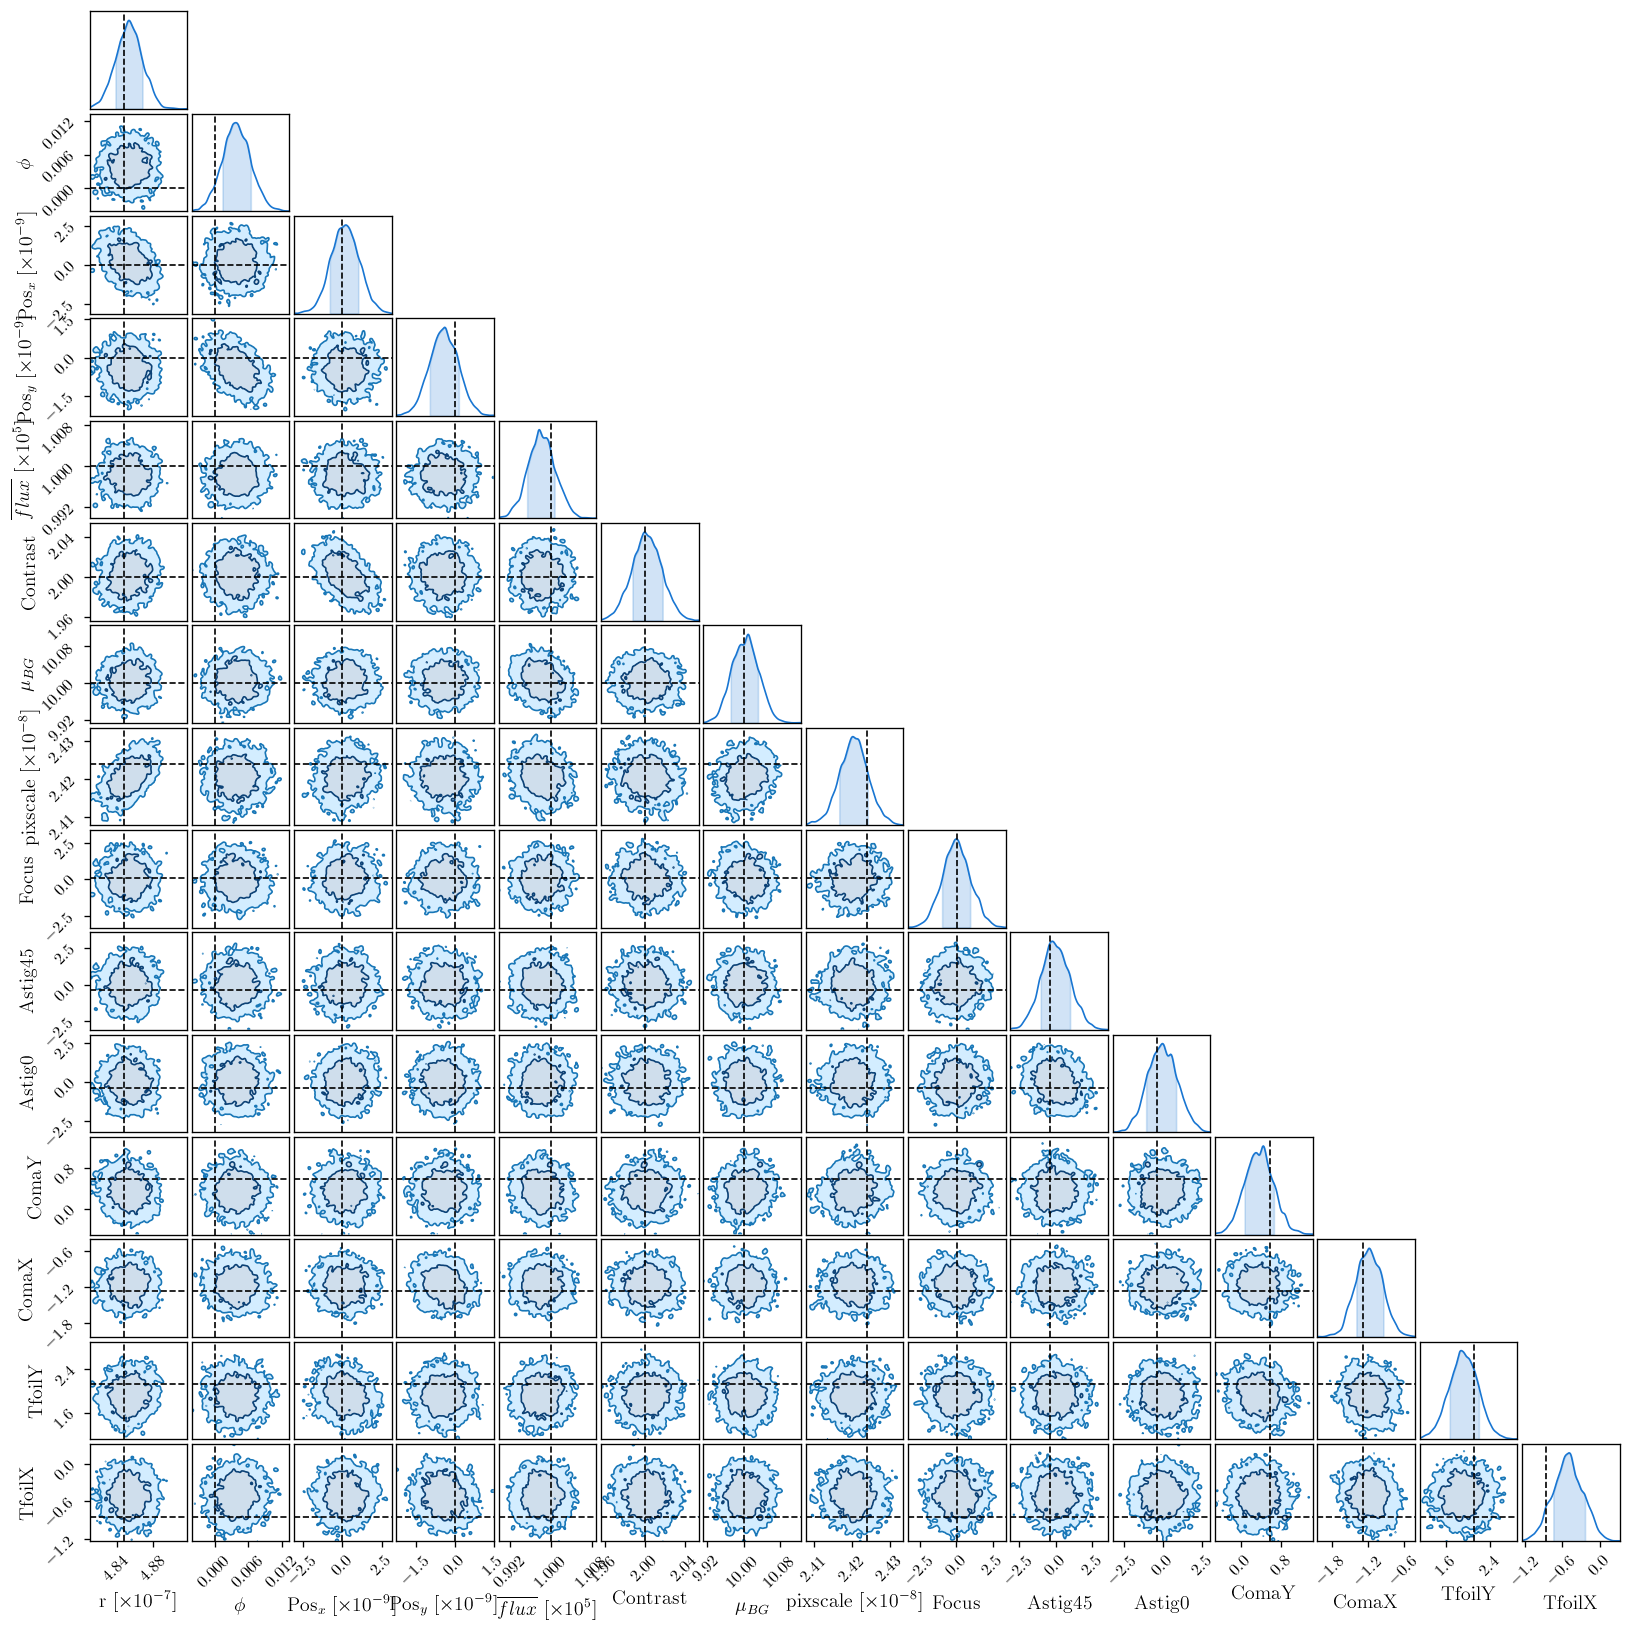

In [138]:
chain = cc.ChainConsumer()
chain.add_chain(chain_dict)
chain.configure(serif=True, shade=True, bar_shade=True, shade_alpha=0.2, spacing=1., max_ticks=3)
fig = chain.plotter.plot(truth=truth_dict_in)
fig.set_size_inches((15,15));
fig.savefig('hmc', dpi=200, facecolor='w')